
# <center>Spatial Analysis of California Housing Data</center>

## <center>Abstract</center>

### <center>Keywords:</center>

## 1. Introduction
In this blog post, I analyze housing prices across California using a combination of geospatial and satellite image data.  The goal is to find a model that can describe the spatial variation in housing prices across California, the "target" variable, **y**.  We'll start by building a simple, linear model that only uses the eight housing market characteristics (i.e. features) in the original dataset described in Pace et al. [1997], **X**, which contains the following columns: 

0) Median income in cluster, 
1) Average age of housing in cluster, 
2) Average rooms in cluster, 
3) Average bedrooms in cluster, 
4) Total population in cluster, 
5) Average occupancy in cluster, 
6) Latitude of cluster centroid, and
7) Longitude of cluster centroid, 

This model provides a baseline for comparison with the more complicated models we'll build later.

Our first code block below loads the california housing dataset, **calh**, plus it does some important prep work.  In particular, we import three packages, *numpy*, *matplotlib*, and *sklearn*.  They can be downloaded and installed via a package manager, pip, etc.  Note, however, that it can be a bit tricky to install matplotlib's Basemap toolkit with all its dependencies (see link below), but Basemap is only needed for the later part of the analysis that includes features from satellite images.  Finally, we define all of our parameters in the first code block (see comments below for details).


### References
Bency, A.J., S. Rallapalli, R.K. Ganti, M. Srivatsa, and B.S. Manjunath (2016), Beyond Spatial Auto-Regressive Models: Predicting Housing Prices with Satellite Imagery, Applications of Computer Vision (WACV), 2017 IEEE Winter Conference, 
http://ieeexplore.ieee.org/abstract/document/7926625/.

Pace, R.K. and R. Barry, Sparse Spatial Autoregressions, Statistics and Probability Letters, 33 (1997) 291-297.

http://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

https://matplotlib.org/basemap/users/installing.html

http://www.irvinalmonte.com/wp-content/uploads/2016/10/IrvinAlmonte_Brief_Spatio-Temporal_Data_R.pdf




In [76]:
%matplotlib inline

import cartopy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.datasets.california_housing import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
# Adjust size of figures
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [59]:
# Define parameters
# Select features by index position
# Run this cell for data description with list of feature names
feature_ids = [0, 1, 2, 3, 4, 5, 6, 7]
test_size = 0.2
test_randomstate = 1
ll_latlon = [38.9, -124.6]
ur_latlon = [42.4, -119.8]

# Download/load california housing data
calh = fetch_california_housing()

# Extract selected features from input dataset
if len(feature_ids) == 1:
    calh_X = calh.data[:, np.newaxis, feature_ids[0]]
else:
    calh_X = calh.data[:, feature_ids]
calh_y = calh.target
# Filter rows of feature array, X, based on ll_latlon and ur_latlon

# Extract separate feature array with only latitude and longitude (needed?)
calh_latlon = calh.data[:, [6, 7]]
#print(calh_latlon[0,:])
#print(calh_X.shape)
print("Description: \n{}\n".format(calh.DESCR))
print("Feature names (in order): \n{}\n".format(calh.feature_names))



Description: 
California housing dataset.

The original database is available from StatLib

    http://lib.stat.cmu.edu/

The data contains 20,640 observations on 9 variables.

This dataset contains the average house value as target variable
and the following input variables (features): average income,
housing average age, average rooms, average bedrooms, population,
average occupation, latitude, and longitude in that order.

References
----------

Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions,
Statistics and Probability Letters, 33 (1997) 291-297.



Feature names (in order): 
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']



In [ ]:
# Split the data and target into training/testing sets
calh_X_train, calh_X_test, calh_y_train, \
    calh_y_test = train_test_split(calh_X, \
        calh.target, test_size=test_size, random_state=test_randomstate
)

In [86]:
# Create linear regression object for modeling
#intercept = 0
#coef = [1000]
#model = linear_model.LinearRegression()
#model.intercept_ = intercept
#model.coef_ = np.array(coef)
# Generate model data using intercept and coef
#calh_y_mod = model.predict(calh_X_test)

# Create linear regression object for inversion
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(calh_X_train, calh_y_train)

# Make predictions using the testing set
calh_y_pred = regr.predict(calh_X_test)

# The coefficients
print("Intercept: {}".format(regr.intercept_))
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: {0:.2f}".format( \
        mean_squared_error(calh_y_test, calh_y_pred))
)
# Explained variance score: 1 is perfect prediction
print("Variance (R^2) score: {0:.2f}".format( \
        r2_score(calh_y_test, calh_y_pred))
)


Intercept: -37.51575415983646
Coefficients: 
 [  4.38565392e-01   9.68722037e-03  -1.04705005e-01   6.32189474e-01
  -3.67690711e-06  -3.44771323e-03  -4.25964056e-01  -4.40601114e-01]
Mean squared error: 0.53
Variance (R^2) score: 0.60


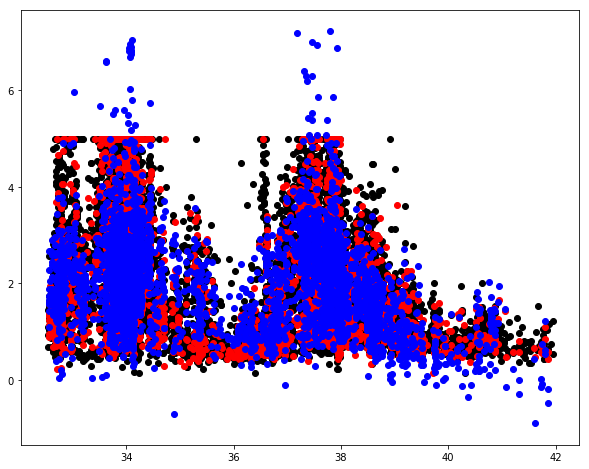

In [87]:
# Plot outputs
plt_featid = 6
plt.scatter(calh_X_train[:,plt_featid], calh_y_train,  color='black')
plt.scatter(calh_X_test[:,plt_featid], calh_y_test,  color='red')
plt.scatter(calh_X_test[:,plt_featid], calh_y_pred, color='blue')
#plt.plot(calh_X_test, calh_y_mod, color='red', linewidth=3)
#print(calh_y_pred)
#plt.xticks(())
#plt.yticks(())

plt.show()


In [3]:
# Define parameters and get lat/lon limits
projection = "merc"
#projection = "cyl"
resolution = "f"
area_thresh = 1
lat_buf = 1
lon_buf = 1
plt_type = "scatter"
gridsize = 20
mincnt = 1
cmap = 'YlOrBr'

if len(ll_latlon) != len(ur_latlon) or len(ll_latlon) != 2:
    ll_latlon = [ \
            calh_latlon[:,0].min() - lat_buf, \
            calh_latlon[:,1].min() - lon_buf
    ]
    ur_latlon = [ \
            calh_latlon[:,0].max() + lat_buf, \
            calh_latlon[:,1].max() + lon_buf
    ]
ll_latlon = np.array(ll_latlon)
ur_latlon = np.array(ur_latlon)
mm_latlon = (ll_latlon + ur_latlon) / 2

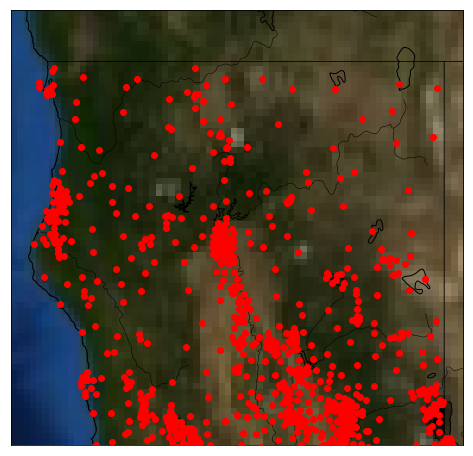

In [88]:
# Generate Map for plotting geolocated data
# Make basemap instance and draw features on it
my_map = Basemap( \
        projection = projection, \
        #epsg = 4326, ellps = "WGS84", \
        lat_0 = mm_latlon[0], lon_0 = mm_latlon[1],
        resolution = resolution, area_thresh = area_thresh,
        llcrnrlon=ll_latlon[1], llcrnrlat=ll_latlon[0],
        urcrnrlon=ur_latlon[1], urcrnrlat=ur_latlon[0]
)
 
my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawstates()
my_map.drawrivers()
#my_map.fillcontinents(color = 'coral')
#my_map.arcgisimage()
my_map.bluemarble()
#my_map.etopo()
#my_map.drawmapboundary()

#print(help(my_map))
if plt_type == "scatter":
    x, y = my_map(calh_latlon[:, 1], calh_latlon[:, 0])
    my_map.scatter(x, y, color='red', marker='o', zorder=10)
elif plt_type == "hexbin":
    x, y = my_map(calh_latlon[:, 1], calh_latlon[:, 0])
    my_map.hexbin(x, y, gridsize=gridsize, mincnt=mincnt, cmap=cmap)
    #my_map.colorbar(location='bottom', label='Count')
    
#my_map.drawmapscale()

plt.show()

In [19]:
# This is a STRM shaded relief map
"""
This example illustrates the automatic download of
STRM data, gap filling (using gdal) and adding shading
to create a so-called "Shaded Relief SRTM".

Originally contributed by Thomas Lecocq (http://geophysique.be).

"""
import cartopy.crs as ccrs
from cartopy.io import srtm
import matplotlib.pyplot as plt

from cartopy.io import PostprocessedRasterSource, LocatedImage
from cartopy.io.srtm import SRTM3Source

def fill_and_shade(located_elevations):
    """
    Given an array of elevations in a LocatedImage, fill any holes in
    the data and add a relief (shadows) to give a realistic 3d appearance.

    """
    new_elevations = srtm.fill_gaps(located_elevations.image, max_distance=15)
    new_img = srtm.add_shading(new_elevations, azimuth=135, altitude=15)
    return LocatedImage(new_img, located_elevations.extent)

ax = plt.axes(projection=ccrs.PlateCarree())

# Define a raster source which uses the SRTM3 data and applies the
# fill_and_shade function when the data is retrieved.
shaded_srtm = PostprocessedRasterSource(SRTM3Source(), fill_and_shade)

# Add the shaded SRTM source to our map with a grayscale colormap.
ax.add_raster(shaded_srtm, cmap='Greys')

# This data is high resolution, so pick a small area which has some
# interesting orography.
#ax.set_extent([ll_latlon[1], ur_latlon[1], ll_latlon[0], ur_latlon[0]])
ax.set_extent([12, 13, 47, 48])

plt.title("SRTM Shaded Relief Map")

gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_left = False

plt.show()

/usr/local/lib/python3.4/dist-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://e4ftl01.cr.usgs.gov/SRTM/SRTMGL3.003/2000.02.11/N47E012.SRTMGL3.hgt.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


HTTPError: HTTP Error 401: Unauthorized

/usr/local/lib/python3.4/dist-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


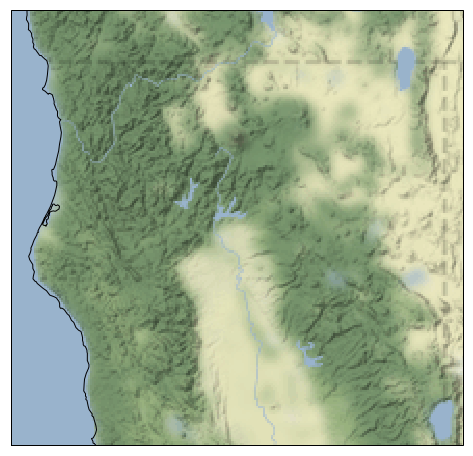

In [21]:
import matplotlib.pyplot as plt

from cartopy.io.img_tiles import StamenTerrain

tiler = StamenTerrain()
mercator = tiler.crs
ax = plt.axes(projection=mercator)
ax.set_extent([ll_latlon[1], ur_latlon[1], ll_latlon[0], ur_latlon[0]])
#ax.set_extent([-90, -73, 22, 34])

ax.add_image(tiler, 6)

ax.coastlines('10m')
plt.show()

In [5]:
# Using Web Map Tile Service (WMPS) to get satellite images
# Following http://www.net-analysis.com/blog/cartopyimages.html
import cartopy.crs as ccrs
#from cartopy.io.img_tiles import OSM
#import cartopy.feature as cfeature
#from cartopy.io import shapereader
#from cartopy.io.img_tiles import StamenTerrain
#from cartopy.io.img_tiles import GoogleTiles
from owslib.wmts import WebMapTileService
#import matplotlib.pyplot as plt
#from matplotlib.path import Path
#import matplotlib.patheffects as PathEffects
#import matplotlib.patches as mpatches
#import numpy as np

In [64]:
# Selecting WTMS tiles
# URL of NASA GIBS
URL = 'http://gibs.earthdata.nasa.gov/wmts/epsg4326/best/wmts.cgi'
wmts = WebMapTileService(URL)
# Layers for MODIS true color and snow RGB
layers = ['MODIS_Terra_SurfaceReflectance_Bands143', \
        'MODIS_Terra_CorrectedReflectance_Bands367']
date_str = '2010-07-12'
# Plotting

fig_dpi = 250
figsize_y = 8
plot_datapoints = True
savefig_name = "NCal_modis_olric_hvals.png"

In [67]:
# Define two coordinate reference systems (i.e. projections)
# and set plot bounding box, etc.
plot_CRS = ccrs.Mercator()
geodetic_CRS = ccrs.Geodetic()

lat0 = ll_latlon[0]
lat1 = ur_latlon[0]
lon0 = ll_latlon[1]
lon1 = ur_latlon[1]
# Calculate x,y pairs for lower-left and upper-right map corners
x0, y0 = plot_CRS.transform_point(lon0, lat0, geodetic_CRS)
x1, y1 = plot_CRS.transform_point(lon1, lat1, geodetic_CRS)
#print("x0, y0: {}, {}".format(x0, y0))
#print("x1, y1: {}, {}".format(x1, y1))
# Calculate x,y pairs for housing data lat/lon pairs
calh_xy = np.zeros((calh_latlon.shape[0], 2))
for ri, (lat, lon) in enumerate(calh_latlon):
    calh_xy[ri,:] = plot_CRS.transform_point(lon, lat, geodetic_CRS)
print(calh_xy[1000,:])
# The following gives aspect ratio for Mercator projection (?)
figsize_x = 2 * figsize_y * (x1 - x0) / (y1 - y0)
fig = plt.figure(figsize=(figsize_x, figsize_y), dpi=fig_dpi)

# Add Satellite image(s) and coastline, then show figure
RIVERS_10m = cartopy.feature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m',
                                 edgecolor=cartopy.feature.COLORS['water'],
                                 facecolor='none', linewidth=2)
RIVERS_NA_10m = cartopy.feature.NaturalEarthFeature('physical', 'rivers_north_america', '10m',
                                 edgecolor=cartopy.feature.COLORS['water'],
                                 facecolor='none', linewidth=1)
LAKES_10m = cartopy.feature.NaturalEarthFeature('physical', 'lakes', '10m',
                                 edgecolor='c',
                                 facecolor='c')
LAKES_NA_10m = cartopy.feature.NaturalEarthFeature('physical', 'lakes_north_america', '10m',
                                 edgecolor='c',
                                 facecolor='c', linewidth=1)
OCEAN_10m = cartopy.feature.NaturalEarthFeature('physical', 'ocean', '10m',
                                 edgecolor='b',
                                 facecolor='b')
MINOR_ISLANDS_COASTLINE_10m = cartopy.feature.NaturalEarthFeature('physical', 'minor_islands_coastline', '10m',
                                 edgecolor='k',
                                 facecolor='none')
COASTLINE_10m = cartopy.feature.NaturalEarthFeature('physical', 'coastline', '10m',
                                 edgecolor='k',
                                 facecolor='none')
BORDERS2_10m = cartopy.feature.NaturalEarthFeature('cultural', 'admin_1_states_provinces',
                                  '10m', edgecolor='grey', facecolor='none')
    #"""country boundaries.""""

ax = plt.axes([0, 0, 1, 1], projection=plot_CRS)
ax.set_xlim((x0, x1))
ax.set_ylim((y0, y1))
ax.add_wmts(wmts, layers[0], wmts_kwargs={'time': date_str})
# Add 
ax.add_feature(OCEAN_10m, zorder=1)
ax.add_feature(LAKES_NA_10m, zorder=1)
ax.add_feature(LAKES_10m, zorder=1)
ax.add_feature(RIVERS_NA_10m, zorder=1)
ax.add_feature(RIVERS_10m, zorder=1)
ax.add_feature(BORDERS2_10m, zorder=2)
ax.add_feature(MINOR_ISLANDS_COASTLINE_10m, zorder=2)
ax.add_feature(COASTLINE_10m, zorder=2)

# Add California housing data points
if plot_datapoints:
    ax.scatter(calh_latlon[:, 1], calh_latlon[:, 0], c=calh_y, cmap='jet', \
               marker='o', edgecolor='none', facecolor='none', \
               alpha=1, zorder=3, transform=ccrs.Geodetic()
    )
minlonind = calh_latlon[:,1].argmin()
maxlatind = calh_latlon[:,0].argmax()
print(calh_latlon[minlonind, :])
print(calh_latlon[maxlatind, :])
#print(help(ax.get_images))
#imax = ax.get_images()
#imdat = imax[0].make_image("png")
#print(help(imax[0].make_image))
plt.savefig(savefig_name,dpi=fig_dpi, bbox_inches='tight')
#plt.show()
plt.close()

[-13554261.19898899   4509598.604617  ]
[  40.54 -124.35]
[  41.95 -124.14]


In [58]:
# Load image that was just written to file and define its x/y grid
# Inspired in part by http://cgcooke.github.io/GDAL/
img  = np.asarray(Image.open(savefig_name))
print(img.shape)
#print(img[1000, 1000, :])
#print(img[img[:, :, 3]==255].shape)

# Define two lists with the x- and y-values of each pixel
yPixels, xPixels, nBand = img.shape  # number of pixels in y, x
pixelXSize =(x1-x0)/xPixels # size of the pixel in X direction     
pixelYSize = (y0-y1)/yPixels # size of the pixel in Y direction
pixelX = np.arange(x0, x1, pixelXSize)
pixelY = np.arange(y1, y0, pixelYSize)
#print(len(pixelX))
#print(len(pixelY))

# Identify image around a given cal housing data point


(2057, 2145, 4)
[ 41  58  14 255]
2145
2057


In [75]:
print(pixelXSize)

249.10655282410795
